In [1]:
import numpy as np
import cv2
import IPython.core.ultratb as tb
import matplotlib.pyplot as plt
import os
import sys
import traceback
import progressbar
import seaborn as sbs
import glob
%matplotlib inline

In [22]:
fname = '/media/somebody/Backyard/Large_Research_Files/Airan/Behavior/Green_Corner/2018-05-22 15-11-22.mov'
try:
    cap.release()
except:
    pass
cap = cv2.VideoCapture(fname)
ret, init_frame = cap.read()
cap.set(cv2.CAP_PROP_POS_MSEC,1000*16)
ret, frame = cap.read()
cap.release()

def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #cv2.namedWindow('Result')
    #cv2.moveWindow('Result',40,30)
    #cv2.imshow('Result',img)
#        
#    cv2.waitKey(0)
#    cv2.destroyAllWindows()


def cv_imshow(img):
    cv2.namedWindow('Result')
    cv2.moveWindow('Result',40,30)
    cv2.imshow('Result',img)
        
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def define_crop_region(frame):
    gray_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img,(5,5),0)
    retval, thresh = cv2.threshold(gray_img,50,255,cv2.THRESH_BINARY)

    im2,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    max_c = max(contours,key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(max_c)
    
    return (x,y,w,h)

def crop(frame,region):
    x,y,w,h = region
    return frame[y:y+h,x:x+w]

def preview_vid(cap,num_frames=30):
    for i in range(num_frames):
        ret, frame = cap.read()
        imshow(frame)
        
def fix_perspective(frame):
    #Segment out the Green Corners
    min_hsv = np.array([45,50,50])
    max_hsv = np.array([75,255,255])
    frame_hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    frame_seg = cv2.inRange(frame_hsv,min_hsv,max_hsv)
    im2,contours,hierarchy = cv2.findContours(frame_seg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours,key=cv2.contourArea)[0:4] #4 Largest Contours
    
    #Find Coordinates of Corners
    corners = np.zeros((4,2))
    for (i,c) in enumerate(contours):
        M = cv2.moments(c)
        corners[i,0] = int(M['m10']/M['m00'])
        corners[i,1] = int(M['m01']/M['m00'])
    
    #Sort into Top Left, etc.
    x_ctr = np.mean(corners[:,0])
    y_ctr = np.mean(corners[:,1])
    sorted_pts = np.zeros((4,2),dtype=np.float32)
    for pt in corners:
        if pt[1] < y_ctr:
            if pt[0] < x_ctr:
                sorted_pts[0,:] = pt #Top Left
            else:
                sorted_pts[1,:] = pt #Top right
        else:
            if pt[0] < x_ctr:
                sorted_pts[2,:] = pt #Bottom Left
            else:
                sorted_pts[3,:] = pt

    world_pts = np.array([[10,10],[590,10],[10,590],[590,590]],dtype=np.float32)
    perspective_transform = cv2.getPerspectiveTransform(sorted_pts,world_pts)

    dst = cv2.warpPerspective(frame_cropped,perspective_transform,(600,600),borderValue=(255,255,255))
    
    return perspective_transform,dst
        
def find_rat(frame):
    gray_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img,(5,5),0)
    retval, thresh = cv2.threshold(blur_img,30,255,cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((5,5),np.uint8)
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    thresh = cv2.dilate(thresh,kernel,iterations = 1)
    
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    thresh = cv2.dilate(thresh,kernel,iterations = 1)
    
    im2,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None,None,None
    
    max_c = max(contours,key=cv2.contourArea)
    M = cv2.moments(max_c)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    return (cx,cy,max_c)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def progress_bar(its):
    return progressbar.ProgressBar(maxval=its,widgets=[progressbar.Bar('=', '[', ']'),
                                                       ' ', progressbar.Percentage()])

def track_rat(fname,corners=None):
    #Import video
    folder,file = os.path.split(fname)
    file = os.path.splitext(file)[0]
    
    cap = cv2.VideoCapture(fname)
    ret, frame = cap.read()
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    
    #Define cropped region
    region = define_crop_region(frame)
    frame_cropped = crop(frame,region)
    
    
    #Identify corners of Open Field
    if corners is not None:
        for pt in corners:
            cv2.circle(frame_cropped,tuple(pt),10,(0,255,0),-1)
        
    perspective_transform,frame_cropped = fix_perspective(frame_cropped)
    
    #Output tracked video
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    ensure_dir(folder + '/Tracked/')
    out = cv2.VideoWriter(folder+'/Tracked/'+file+'_tracked.avi',fourcc, 2*fps,(frame_cropped.shape[1],frame_cropped.shape[0]))
    
    #Position Matrix
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    rat_pos = np.zeros((num_frames,3),dtype=float)
    rat_pos[:,0] = np.arange(num_frames,dtype=float)/fps
    rat_pos[:,1:] = np.NaN
    
    
    try:        
        bar = progress_bar(num_frames-1)
        bar.start()
        while ret:
            frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES))-1
            frame_cropped = crop(frame,region)
            frame_cropped = cv2.warpPerspective(frame_cropped,perspective_transform,(600,600),borderValue=(255,255,255))
            cx,cy,rat = find_rat(frame_cropped)
            
            if rat is None:
                rat_pos[frame_num,1] = np.NaN
                rat_pos[frame_num,2] = np.NaN
            else:
                rat_pos[frame_num,1] = cx
                rat_pos[frame_num,2] = cy
                
                if frame_num % 2 == 0:
                    pts = rat_pos.copy()[0:frame_num,1:]
                    pts = pts[~np.isnan(pts).any(axis=1)]
                    pts = pts.reshape((-1,1,2)).astype(np.int32)
                    annotated = cv2.polylines(frame_cropped.copy(),[pts],False,(180,119,31),2)
                    cv2.drawContours(annotated, [rat], -1, (14,127,255), 3)
                    
                    out.write(annotated)
            
            ret, frame = cap.read()
            
            
            bar.update(frame_num)
            
        bar.finish()
        cap.release()
        out.release()
        
        rat_pos = rat_pos[~np.isnan(rat_pos).any(axis=1)] #Trim out any NaN
        rat_pos = rat_pos[2*int(fps):,:] #Trim out the first half second with the hand
        return rat_pos
    except Exception as err:
        cap.release()
        out.release()
        #print(err)
        #traceback.print_exc()
        err_tb = tb.VerboseTB()
        print(err_tb.text(*sys.exc_info()))
        #print(traceback.format_exc())#print_tb(err.__traceback__)
        
def track_folder(folder,corners=None):
    all_vids = glob.glob(folder+'/*.mov')
    for vid in all_vids:
        basename = os.path.basename(vid)
        print('Working on ' + basename)
        if os.path.isfile(folder+'/' + basename + '.csv'):
            print('Already Tracked')
            continue
        rat_pos = track_rat(vid,corners=corners)
        
        np.savetxt(folder + '/' + basename + '.csv',rat_pos,delimiter=',',header='Time (s),x (AU),y (AU)')
        
        #Summary stats
        total_time = rat_pos[-1,0] - rat_pos[0,0]
        avg_speed = np.sum(np.diff(rat_pos,axis=0)[:,1:]**2) / total_time
        
        #Find times when rat is in the center
        x_lim = [10,590]
        y_lim = [10,590]
        
        x_len = x_lim[1] - x_lim[0]
        y_len = y_lim[1] - y_lim[0]
        
        x_criteria = np.logical_and((rat_pos[:,1] - x_lim[0]) / x_len > 1/3.0,
                                    (rat_pos[:,1] - x_lim[0]) / x_len < 2/3.0)
        y_criteria = np.logical_and((rat_pos[:,2] - y_lim[0]) / y_len > 1/3.0,
                                    (rat_pos[:,2] - y_lim[0]) / y_len < 2/3.0)
        center_criteria = np.logical_and(x_criteria,y_criteria)
        
        time_center = 100*np.sum(center_criteria) / len(center_criteria)
        
        num_center = np.sum(np.diff(center_criteria.astype(int))==1) / (total_time/60)
        
        #Check if summary exists
        if not os.path.isfile(folder+'/Summary.csv'):
            with open(folder+'/Summary.csv','w+') as summary_f:
                summary_f.write('File Name,Total Time (s),Average Speed (AU/sec),Percent Time Spent in Center,Number Times Crossed into Center per Minute\n')
                summary_f.write(basename+','+str(total_time)+','+str(avg_speed)+','+str(time_center)+','+str(num_center)+'\n')
        else:
            with open(folder+'/Summary.csv','a+') as summary_f:
                summary_f.write(basename+','+str(total_time)+','+str(avg_speed)+','+str(time_center)+','+str(num_center)+'\n')
                
    print('All Done!')

In [23]:
folder,file = os.path.split(fname)
track_folder(folder)
#track_folder(folder,corners=[[75,0],[563,0],[85,459],[545,461]])

Working on 2018-05-22 15-11-22.mov


All Done!


[========================================================================] 100%


In [30]:
rat_pos = track_rat(fname,corners=[[75,0],[563,0],[85,459],[545,461]])

[========================================================================] 100%


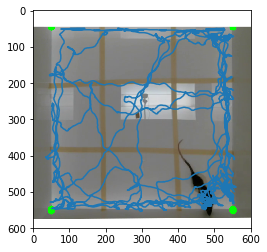

In [35]:
imshow(dst)
plt.plot(rat_pos[:,1],rat_pos[:,2])

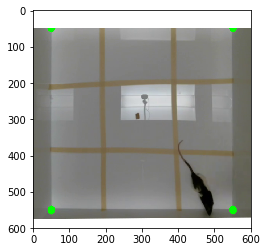

In [62]:
x_ctr = np.mean(pts[:,0])
y_ctr = np.mean(pts[:,1])
sorted_pts = np.zeros((4,2),dtype=np.float32)
for pt in pts:
    if pt[1] < y_ctr:
        if pt[0] < x_ctr:
            sorted_pts[0,:] = pt #Top Left
        else:
            sorted_pts[1,:] = pt #Top right
    else:
        if pt[0] < x_ctr:
            sorted_pts[2,:] = pt #Bottom Lefta
        else:
            sorted_pts[3,:] = pt

M = cv2.getPerspectiveTransform(sorted_pts,world_pts)
#M = M.dot(np.array([[1,0,50],[0,1,0],[0,0,1]]))

dst = cv2.warpPerspective(frame_cropped,M,(600,600),borderValue=(255,255,255))
imshow(dst)

In [40]:
print(world_pts.shape)
print(sorted_pts.shape)

(4, 2)
(4, 2)


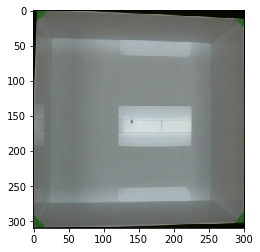

In [15]:
#pts = np.array([[75,0],[563,0],[85,459],[545,461]],dtype=np.float32)
world_pts = np.array([[0,50],[600,0],[0,600],[600,600]],dtype=np.float32)
#for pt in pts:
#    cv2.circle(frame_cropped,tuple(pt),10,(0,255,0),-1)
imshow(frame_cropped)

In [36]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, cap.get(cv2.CAP_PROP_FPS),
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

TypeError: integer argument expected, got float

In [9]:
cap.release()

In [ ]:

folder,file = os.path.split(fname)

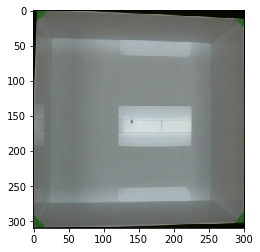

In [5]:
region = define_crop_region(init_frame)
frame_cropped = crop(frame,region)
cx,cy,rat = find_rat(frame_cropped)
#test = cv2.drawContours(frame_cropped.copy(), [rat], -1, (0,255,0), 3)
imshow(frame_cropped)

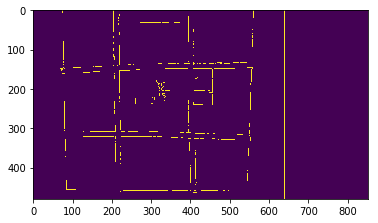

In [50]:
edges = cv2.Canny(init_frame,50,100)
plt.imshow(edges)

In [75]:
cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)[0,75]

array([ 60, 255, 255], dtype=uint8)

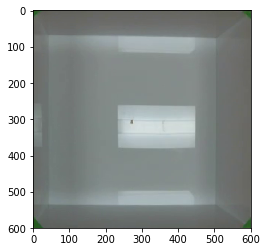

In [21]:
min_hsv = np.array([45,50,50])
max_hsv = np.array([75,255,255])
#cv_imshow(frame_cropped)
frame_hsv = cv2.cvtColor(frame_cropped,cv2.COLOR_BGR2HSV)
frame_seg = cv2.inRange(frame_hsv,min_hsv,max_hsv)
im2,contours,hierarchy = cv2.findContours(frame_seg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours,key=cv2.contourArea)[0:4] #4 Largest Contours

plt.imshow(frame_seg)
corners = np.zeros((4,2))
for (i,c) in enumerate(contours):
    M = cv2.moments(c)
    corners[i,0] = int(M['m10']/M['m00'])
    corners[i,1] = int(M['m01']/M['m00'])

    
x_ctr = np.mean(corners[:,0])
y_ctr = np.mean(corners[:,1])
sorted_pts = np.zeros((4,2),dtype=np.float32)
for pt in corners:
    if pt[1] < y_ctr:
        if pt[0] < x_ctr:
            sorted_pts[0,:] = pt #Top Left
        else:
            sorted_pts[1,:] = pt #Top right
    else:
        if pt[0] < x_ctr:
            sorted_pts[2,:] = pt #Bottom Left
        else:
            sorted_pts[3,:] = pt

world_pts = np.array([[10,0],[590,10],[10,590],[590,590]],dtype=np.float32)
perspective_transform = cv2.getPerspectiveTransform(sorted_pts,world_pts)

dst = cv2.warpPerspective(frame_cropped,perspective_transform,(600,600),borderValue=(255,255,255))
imshow(dst)

In [13]:
cv2.cvtColor(frame_cropped,cv2.COLOR_BGR2HSV)[298,297]

array([ 58, 132,  91], dtype=uint8)

In [21]:
test = cv2.drawContours(frame_cropped.copy(), [hull], -1, (0,255,0), 3)
imshow(test)

In [ ]:
frame = 